## Importing the Libraries

In [1]:
import tensorflow as tf
#import tensorflow_addons as tfa
import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model
#from tensorflow.keras.models import models
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import sys
import sklearn
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score, confusion_matrix
#%matplotlib inline
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.models import load_model
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score, confusion_matrix
from scipy import misc
#from tqdm import tqdm

Using TensorFlow backend.


In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [35]:
def binary(img):
    ret, img = cv2.threshold (img, 127, 255, cv2.THRESH_BINARY)
    img = np.array (img, dtype=np.uint8)
    mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)*255
    img = cv2.bitwise_xor(img,mask)
    img = img//255
    img = np.reshape(img,(img.shape[0],img.shape[1]))
    img = np.array(img,dtype=np.uint8)
    
    return img

## Loading the Data

Defining a function to load the data in sorted order

In [36]:
y_train1=[]

for i in sorted(glob.glob('./Dataset320/y_train/*.png'), key=numericalSort):
    img = cv2.imread(i) # Read image here
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(320,320))
    
   
    out=binary(img)
   
    y_train1.append(out)


In [37]:
x_train1=[]

for i in sorted(glob.glob('./Dataset320/x_train/*.jpg'), key=numericalSort):
    img = cv2.imread(i) # Read image here
    
    x_train1.append(img)


In [38]:
x_test=[]

for i in sorted(glob.glob('./Dataset320/x_test/*.jpg'), key=numericalSort):
    img = cv2.imread(i) # Read image here
    
    x_test.append(img)
    
    
x_test=np.array(x_test)

In [39]:
y_test=[]

for i in sorted(glob.glob('./Dataset320/y_test/*.png'), key=numericalSort):
    img = cv2.imread(i) # Read image here
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(320,320))
    
    #out = cv2.normalize(img.astype('double'), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    out=binary(img)
    #out.save()
    y_test.append(out)
    
    
    
y_test=np.array(y_test)

Let's plot an image to see how the original images look.

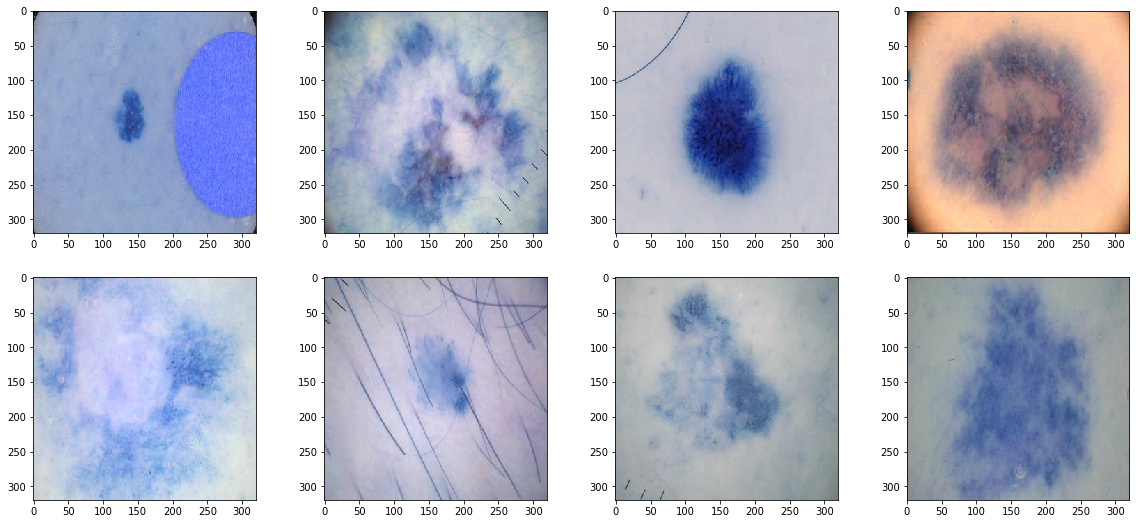

In [40]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_train[0])
plt.subplot(2,4,2)
plt.imshow(x_train[3])
plt.subplot(2,4,3)
plt.imshow(x_train[54])
plt.subplot(2,4,4)
plt.imshow(x_train[77])
plt.subplot(2,4,5)
plt.imshow(x_train[100])
plt.subplot(2,4,6)
plt.imshow(x_train[125])
plt.subplot(2,4,7)
plt.imshow(x_train[130])
plt.subplot(2,4,8)
plt.imshow(x_train[149])
plt.show()


Now let's see their corresponding masks.

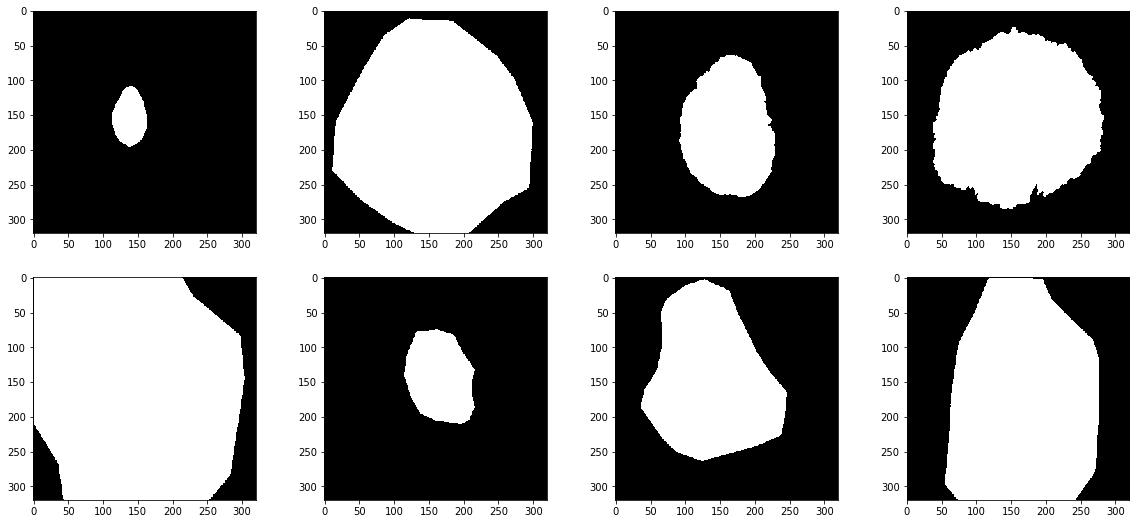

In [89]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(y_train1[0],cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(y_train1[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(y_train1[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(y_train1[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(y_train1[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(y_train[149], cmap = plt.cm.gray)
plt.show()

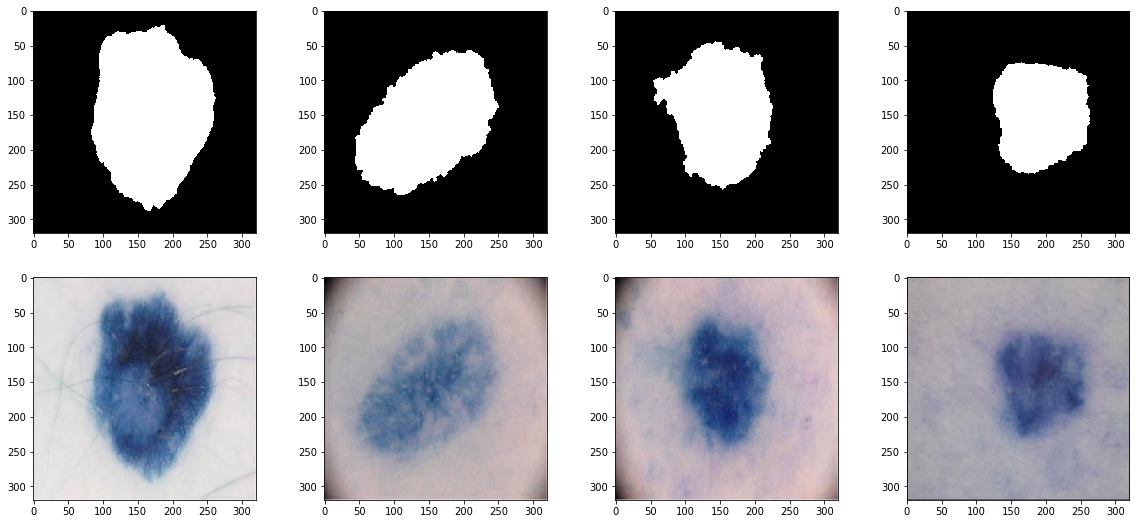

In [43]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(y_test[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(y_test[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(y_test[4], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(y_test[7], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(x_test[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(x_test[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(x_test[4], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(x_test[7], cmap = plt.cm.binary_r)
plt.show()

In [44]:
x_train2=np.array(x_train1)
y_train2=np.array(y_train1)


Making Validation Set

In [45]:
x_train, x_val, y_train, y_val = train_test_split(x_train2, y_train2, test_size = 0.20, random_state = 101)

## Defining Evaluation Metrics

#### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

#### Dice coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

#### Precision    
Precision is a good measure to determine, when the costs of False Positive is high.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

#### Recall  
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

#### Accuracy

In [81]:



def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    union = K.sum(y_true_f)+K.sum(y_pred_f)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = K.mean((2. * intersection + smooth)/(union + smooth))
    return dice



def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

Image Augmentation¶


To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for random rotation and one for horizontal flipping

In [46]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [47]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [49]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

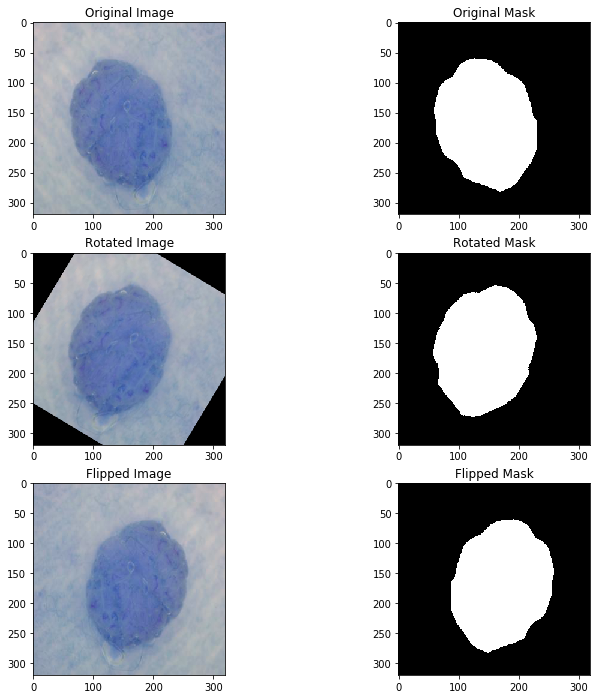

In [51]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [52]:
x_train1 = np.concatenate([x_train, x_rotated, x_flipped])
y_train1 = np.concatenate([y_train, y_rotated, y_flipped])


validation data

In [22]:
#x_train, x_val, y_train, y_val = train_test_split(x_train2, y_train2, test_size = 0.20, random_state = 101)

In [11]:
#x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size = 0.20, random_state = 200)

In [28]:
print("Length of the Training Set   : {}".format(len(x_train1)))
print("Length of the Training Set   : {}".format(len(y_train1)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Test Set   : {}".format(len(y_test)))
print("Length of the Validation Set : {}".format(len(x_val)))
print("Length of the Validation Set   : {}".format(len(y_val)))

Length of the Training Set   : 2160
Length of the Training Set   : 2160
Length of the Test Set       : 379
Length of the Training Set   : 379
Length of the Validation Set : 180
Length of the Training Set   : 180


In [29]:
print(x_train1.shape)
print(x_val.shape)
print(y_train1.shape)

(2160, 320, 320, 3)
(180, 320, 320, 3)
(2160, 320, 320)


## The Model

Defining the model in a function which takes two arguments when called
* **epoch_num**: number of epochs to run  
* **savename**: the name of the model for saving after training

#### Optimizer and Learning Rate  
* We adopt SGD optimization algorithm, to adjust the learning rate.   
* It is well known that learning rate is one of the critical hyperparameters that have a signiﬁcant impact on classiﬁcation performance.     
* On large datasets, SGD can converge faster than batch training because it performs updates more frequently. We can get away with this because the data often contains redundant information, so the gradient can be reasonably approximated without using the full dataset. Minibatch training can be faster than training on single data points because it can take advantage of vectorized operations to process the entire minibatch at once. The stochastic nature of online/minibatch training can also make it possible to hop out of local minima that might otherwise trap batch training.
* The learning rate is the conventional 0.001.

### Model Function

![arch](https://www.researchgate.net/profile/Adam_Czajka2/publication/326151825/figure/fig2/AS:647447659438083@1531374959468/Encoder-decoder-architecture-of-SegNet-Inference-takes-place-from-left-to-right-Size-of.png)

* The architecture we are implementing is suggested in [this](https://arxiv.org/pdf/1511.00561.pdf) paper.
* The advised parameters can't exactly be applied to our problem.  
* We will switch the final activation function from **Softmax** to **Sigmoid** as using softmax was producing blank dark images.  
* The loss function in segnet is suggested **categorical crossentropy** due to it's genral use of muliclass segmentation problem but in our case we only have 1 class i.e. the melanoma. So, we will use **binary crossentropy**


In [82]:
def segnet(epochs_num,savename):
    # Encoding layer
    img_input = Input(shape= (320,320, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)   
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
  

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    
    x = Dense(1024, activation = 'relu', name='fc2')(x)
   
    
    # Decoding Layer 

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    
    x = Activation('sigmoid')(x)

    pred=Reshape((320,320))(x)

   
   
    model=Model(inputs=img_input, outputs=pred)
  
    model.compile(optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0001),
                  loss= ['binary_crossentropy'],metrics=[iou, dice_coef,precision, recall,accuracy])
   
   
    hist = model.fit(x_train1,y_train1,batch_size=3, epochs= epochs_num, validation_data= (x_val,y_val),verbose=1)
    
    model.save(savename)
    
 
    return model,hist
  

In [83]:
model, hist = segnet(5, 'segnet_5_epoch.h5')

Train on 2160 samples, validate on 180 samples
Epoch 1/5
2160/2160 [==============================] - 171s 79ms/step - loss: 0.4364 - iou: 0.3588 - dice_coef: 0.5207 - precision: 0.7290 - recall: 0.7989 - accuracy: 0.8504 - val_loss: 0.4501 - val_iou: 0.3316 - val_dice_coef: 0.4899 - val_precision: 0.8209 - val_recall: 0.4772 - val_accuracy: 0.8200
Epoch 2/5
2160/2160 [==============================] - 166s 77ms/step - loss: 0.3224 - iou: 0.4410 - dice_coef: 0.6058 - precision: 0.8099 - recall: 0.8224 - accuracy: 0.8924 - val_loss: 0.3251 - val_iou: 0.4089 - val_dice_coef: 0.5757 - val_precision: 0.9696 - val_recall: 0.5993 - val_accuracy: 0.8738
Epoch 3/5
2160/2160 [==============================] - 166s 77ms/step - loss: 0.2643 - iou: 0.5039 - dice_coef: 0.6636 - precision: 0.8451 - recall: 0.8433 - accuracy: 0.9118 - val_loss: 0.2496 - val_iou: 0.5851 - val_dice_coef: 0.7306 - val_precision: 0.8065 - val_recall: 0.8930 - val_accuracy: 0.9107
Epoch 4/5
2160/2160 [====================

## Loading the Model

Here we can load a pretrained model

In [84]:
    # Encoding layer
    img_input = Input(shape= (320,320, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
   
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
  

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    
    x = Dense(1024, activation = 'relu', name='fc2')(x)
   
    
    # Decoding Layer 

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    #x = Reshape(320,320, activation = 'sigmoid')(x)
    x = Activation('sigmoid')(x)
   
    pred=Reshape((320,320))(x)

In [85]:
model_0 = Model(inputs=img_input, outputs=pred)
model_0.compile(optimizer= Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0005), loss= ['binary_crossentropy'], metrics=[iou, dice_coef,precision, recall,accuracy])
#model_0.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"], metrics=[iou, dice_coef, precision, recall, accuracy])


In [86]:
model_0.load_weights('segnet_5_epoch.h5')

In [87]:
print('\n~~~~~~~~~~~~~~~Stats after 5 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train1, y_train1, batch_size= 3)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 3)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 3)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 5 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

2160/2160 [==============================] - 52s 24ms/step
________________________
IOU:       |   60.62  |
Dice Coef: |   75.12  |
Precision: |   92.92  |
Recall:    |   79.13  |
Accuracy:  |   92.58  |
Loss:      |   19.41  |
________________________

-------------On Test  Set--------------------------

379/379 [==============================] - 9s 23ms/step
________________________
IOU:       |   60.42  |
Dice Coef: |   74.45  |
Precision: |   91.56  |
Recall:    |   79.48  |
Accuracy:  |   92.05  |
Loss:      |   20.06  |
________________________

-------------On validation Set---------------------

180/180 [==============================] - 4s 23ms/step
________________________
IOU:       |   60.55  |
Dice Coef: |   74.93  |
Precision: |   92.85  |
Recall:    |   77.57  |
Accuracy:  |   91.85  |
Loss:      |   21.16  |
________________________


#### After 100 epochs

In [88]:
model, hist = segnet(epochs_num= 100, savename= 'segnet_100_epoch.h5')

Train on 2160 samples, validate on 180 samples
Epoch 1/100
2160/2160 [==============================] - 171s 79ms/step - loss: 0.4464 - iou: 0.3503 - dice_coef: 0.5115 - precision: 0.7166 - recall: 0.7723 - accuracy: 0.8485 - val_loss: 0.3956 - val_iou: 0.3969 - val_dice_coef: 0.5625 - val_precision: 0.7859 - val_recall: 0.7157 - val_accuracy: 0.8595
Epoch 2/100
2160/2160 [==============================] - 166s 77ms/step - loss: 0.3256 - iou: 0.4331 - dice_coef: 0.5974 - precision: 0.8124 - recall: 0.8090 - accuracy: 0.8913 - val_loss: 0.4036 - val_iou: 0.5183 - val_dice_coef: 0.6746 - val_precision: 0.8480 - val_recall: 0.8250 - val_accuracy: 0.9036
Epoch 3/100
2160/2160 [==============================] - 166s 77ms/step - loss: 0.2700 - iou: 0.4936 - dice_coef: 0.6545 - precision: 0.8470 - recall: 0.8285 - accuracy: 0.9078 - val_loss: 0.2273 - val_iou: 0.5934 - val_dice_coef: 0.7382 - val_precision: 0.9225 - val_recall: 0.7693 - val_accuracy: 0.9156
Epoch 4/100
2160/2160 [============

In [90]:


model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=0.0005), loss= ['binary_crossentropy'], metrics=[iou, dice_coef,precision, recall,accuracy])



In [91]:
model_1.load_weights('segnet_100_epoch.h5')

Testing the statistics after 150 epochs

In [94]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train1, y_train1, batch_size= 5)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 5)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 5)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

2160/2160 [==============================] - 51s 23ms/step
________________________
IOU:       |   90.60  |
Dice Coef: |   95.06  |
Precision: |   99.35  |
Recall:    |   94.70  |
Accuracy:  |   98.50  |
Loss:      |   3.68  |
________________________

-------------On Test  Set--------------------------

379/379 [==============================] - 9s 23ms/step
________________________
IOU:       |   78.13  |
Dice Coef: |   87.39  |
Precision: |   92.01  |
Recall:    |   87.10  |
Accuracy:  |   94.49  |
Loss:      |   17.29  |
________________________

-------------On validation Set---------------------

180/180 [==============================] - 4s 23ms/step
________________________
IOU:       |   79.95  |
Dice Coef: |   88.73  |
Precision: |   93.85  |
Recall:    |   87.59  |
Accuracy:  |   94.66  |
Loss:      |   17.69  |
________________________


### Plotting Training Statistics

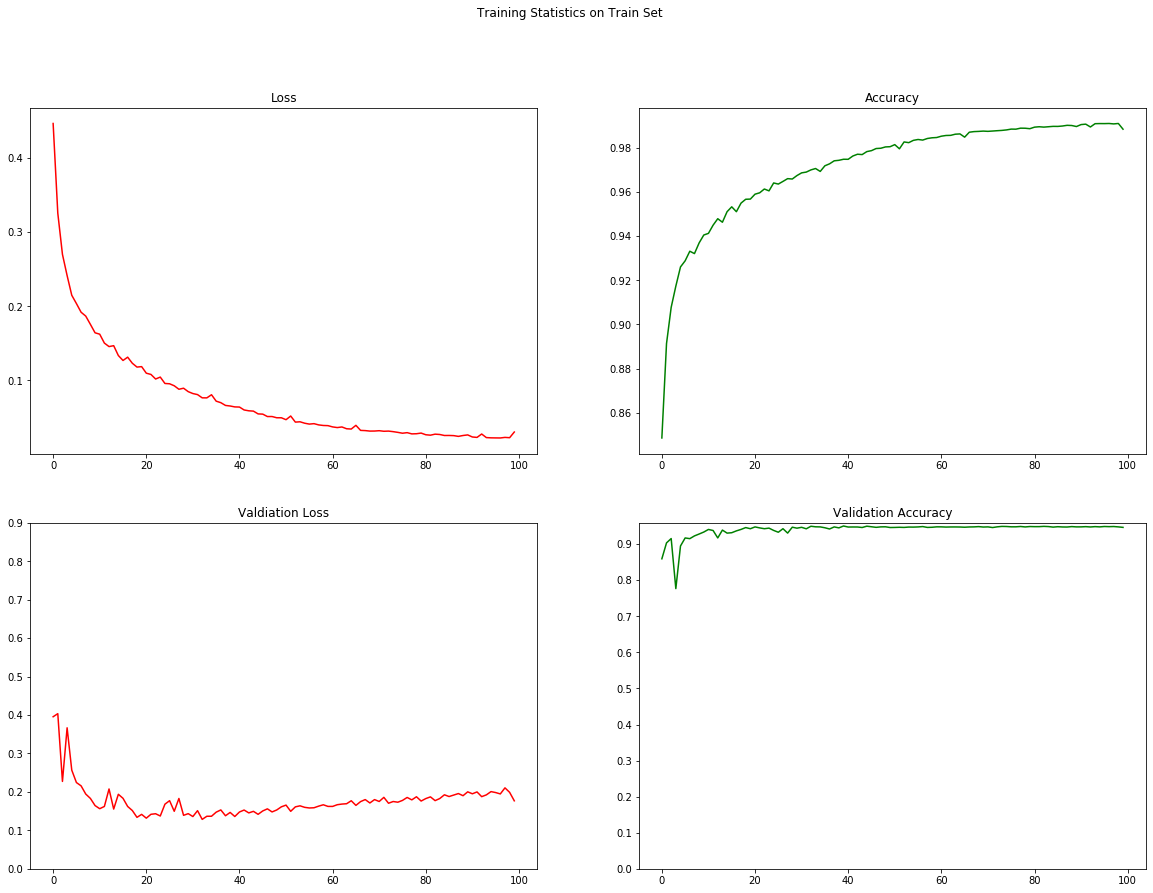

In [95]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

## Visualising Predicted Lesions

We have trained the model on the **training set**.  
We will make predictions on the unseen **test set**

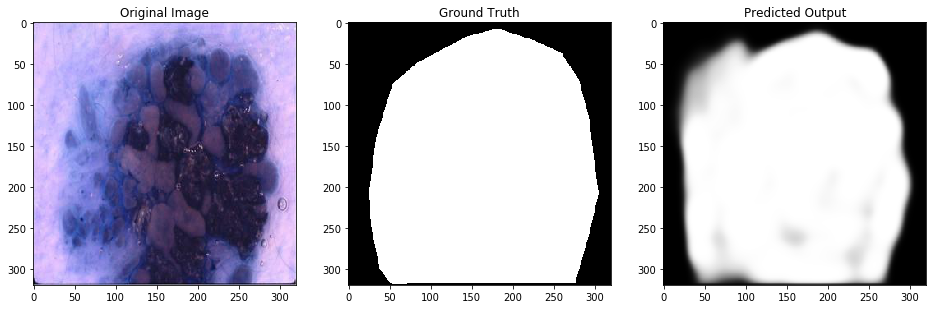

In [96]:
img_num = 49
img_pred = model_0.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320, 320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

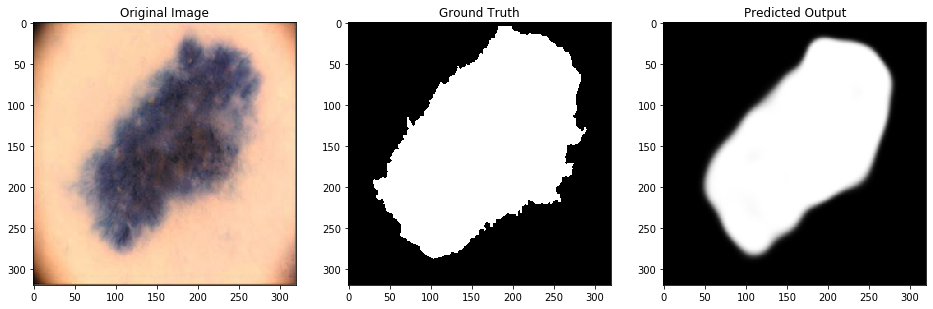

In [97]:
img_num = 10
img_pred = model_1.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320,320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

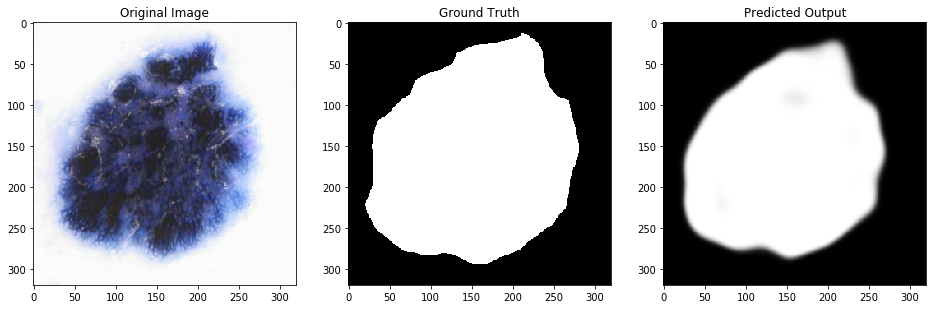

In [98]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320,320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

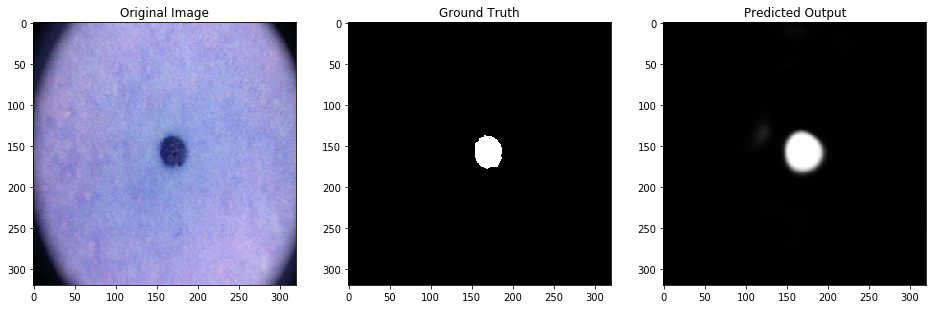

In [99]:
img_num = 32
img_pred = model_1.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320,320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

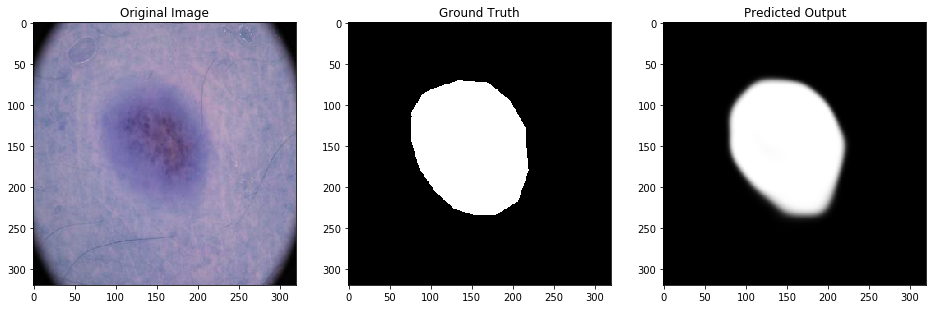

In [100]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320, 320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

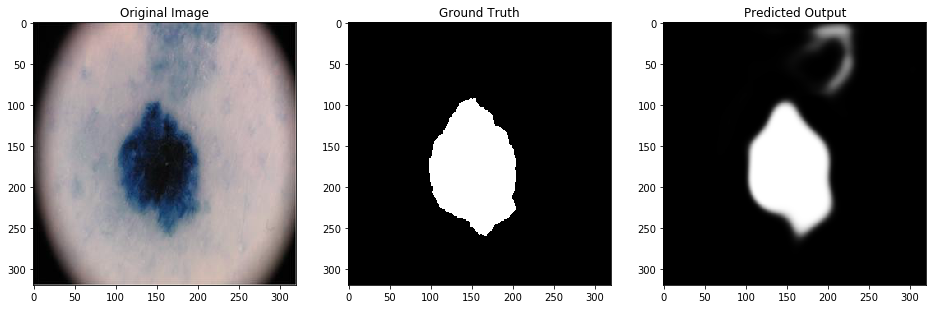

In [101]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320, 320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

## Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.  
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5  .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values.

In [102]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,320,320,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



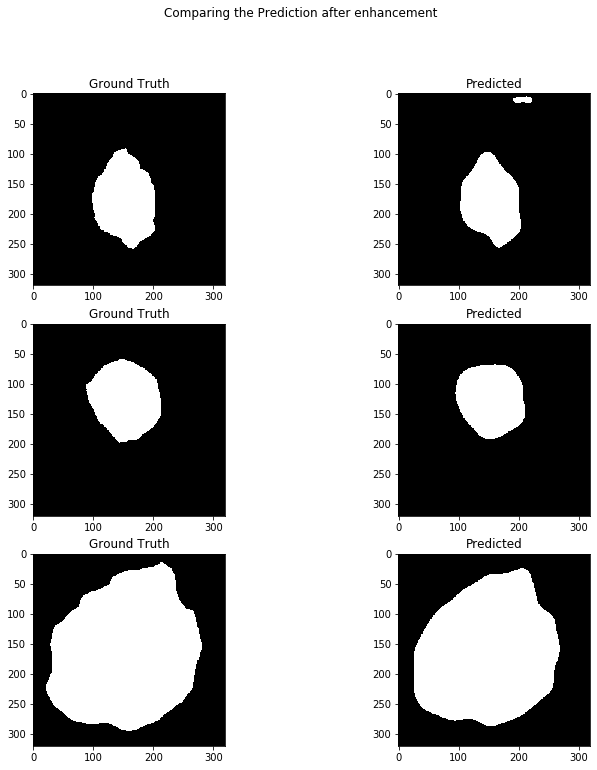

In [103]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

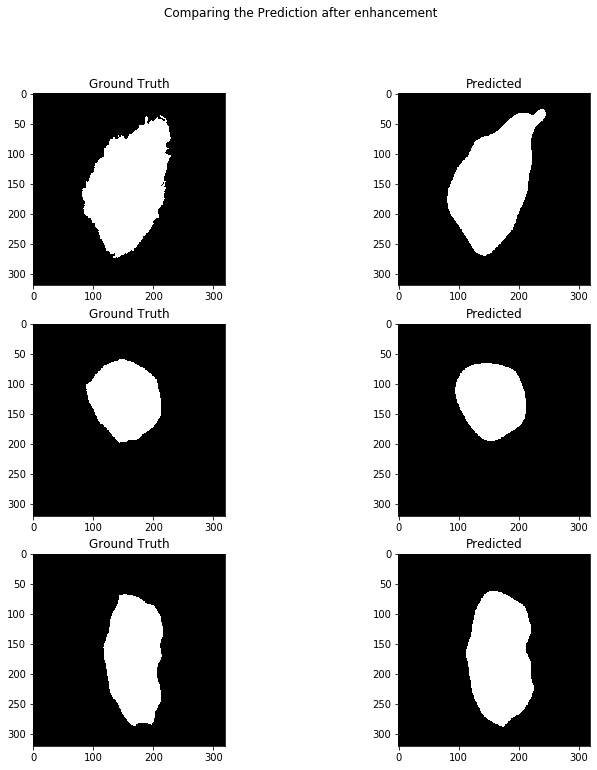

In [57]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[22],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[22]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[30],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[30]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

#

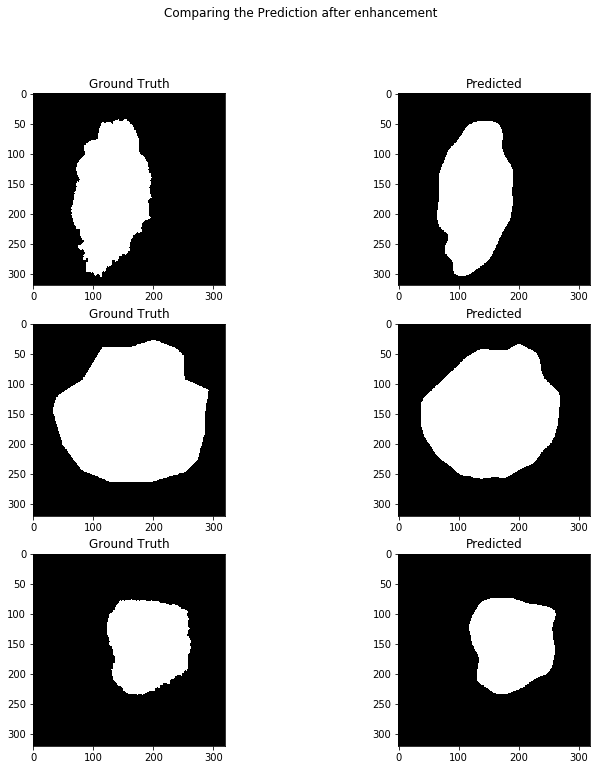

In [60]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[5],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[5]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[6],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[6]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[7],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[7]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

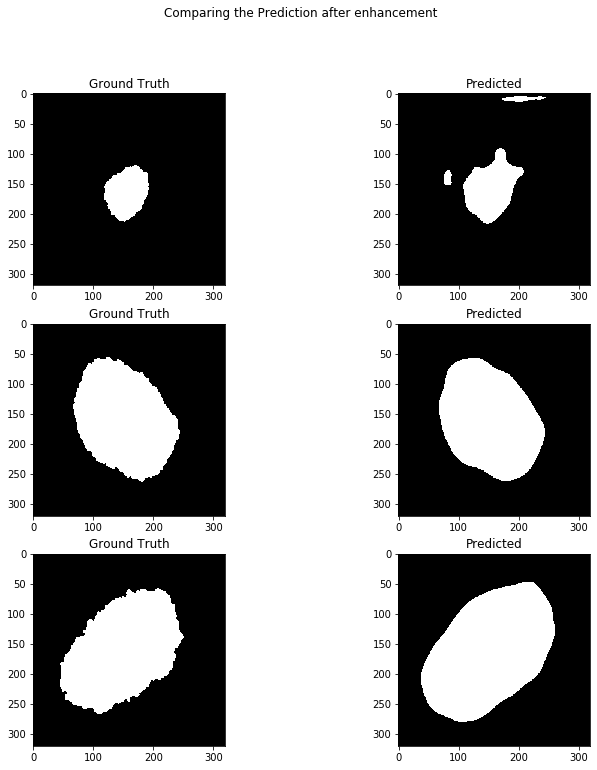

In [61]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[1],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[1]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[2],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[2]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[3],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[3]).reshape(320,320), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

In [59]:
#References : https://www.kaggle.com/hashbanger/skin-lesion-segmentation-using-segnet/commentsReferences : 